In [34]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error


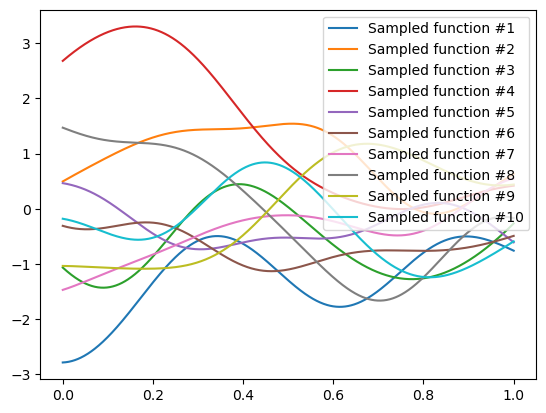

In [5]:
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-1,10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=2)

N = 31 * 29 + 1
t = np.linspace(0,1,N)
dt = t[1]-t[0]

X = t.reshape(-1, 1)
n_samples=10

y_samples = gpr.sample_y(X, n_samples)

plt.figure()
for idx, single_prior in enumerate(y_samples.T):
    plt.plot(
        t,
        single_prior,
        # linestyle="--",
        # alpha=0.7,
        label=f"Sampled function #{idx + 1}",
    )

plt.legend()

forcing_terms = y_samples.T

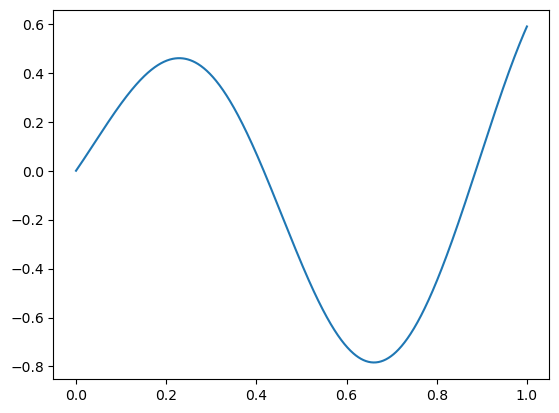

In [6]:
dt = t[1]-t[0]
    
def f(t,u, force):
    k = 9.81/0.2
    u0 = u[1]
    u1 = -k*np.sin(u[0]) + force[int(t/dt)]
    U = np.array([u0, u1])
    return U

plt.figure()
# for ft in forcing_terms:
#     sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,ft), y0=[0,0], t_span=[0,1],t_eval=t)
#     plt.plot(sol.t, sol.y[1])
sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,forcing_terms[3]), y0=[0,0], t_span=[0,1],t_eval=t)
plt.plot(sol.t, sol.y[1])

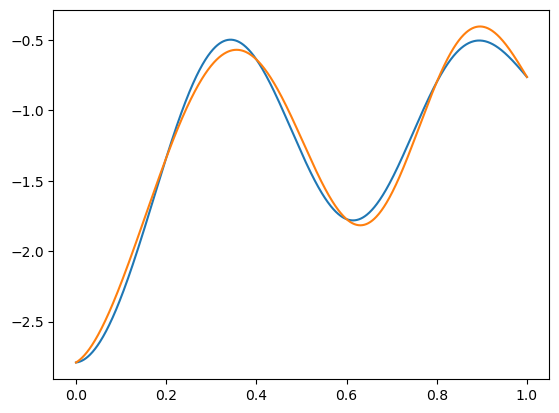

In [7]:
plt.plot(t,forcing_terms[0])
beta = 0.1
plt.plot(t, forcing_terms[0] +  beta * np.sin(5 * np.pi * t))

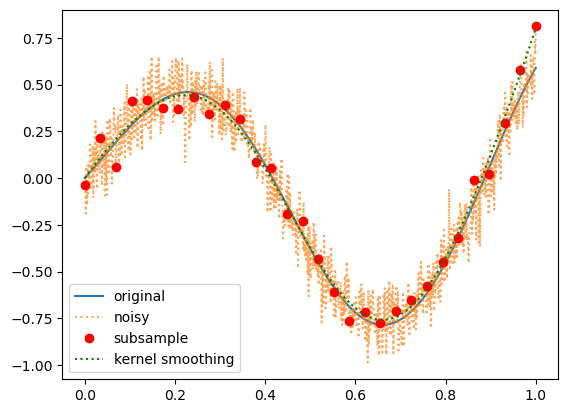

In [8]:
ut = sol.y[1]
noise = np.random.normal(0,0.1,N)
ut_perturbed = ut + noise

u_sample = ut_perturbed[::31]
t_sample = t[::31]

T_train = t_sample.reshape(-1,1)

UXX = rbf_kernel(T_train, T_train, gamma=1)

lam = 1e-4
UXX_inv_u = np.linalg.solve(UXX + lam**2*np.eye(30), u_sample)
T_test = t.reshape(-1,1)
UxX = rbf_kernel(T_test, T_train, gamma=1)
smoothed = UxX @ UXX_inv_u

plt.figure()
plt.plot(t, ut, '-', label='original')
plt.plot(t, ut_perturbed, ':', alpha=0.7, label='noisy')
plt.plot(t_sample, u_sample,'ro', label='subsample')
plt.plot(t, smoothed, 'g:', label='kernel smoothing')
plt.legend()
plt.show()

In [9]:
data = []
t_sample = t[::31]
for ft in forcing_terms:
    sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,ft), y0=[0,0], t_span=[0,1],t_eval=t)
    u = sol.y[0]
    ut = sol.y[1]
    noise = np.random.normal(0,0.1,N)
    ut_perturbed = ut + noise
    u_perturbed = u + noise

    ut_sample = ut_perturbed[::31]
    u_sample = u_perturbed[::31]

    data.append([u_sample, ut_sample, t_sample])

data = np.array(data)
data.shape

(10, 3, 30)

In [23]:
u = sol.y[0]
u_std = np.std(u)
print(u_std)

0.01689052888147609


In [24]:
ut = sol.y[1]
u = sol.y[0]
u_std = np.std(u)
noise = np.random.normal(0,0.1*u_std,N)
u_perturbed = u + noise
u_t_perturbed = ut + noise

scaler = StandardScaler()

t_sample = t[::31]
u_sample = u_perturbed[::31]
u_t_sample = u_t_perturbed[::31]

In [64]:

u_true_sample = u[::31]

def Kt(X, Y, col, l):
    K = RBF(length_scale=l)
    coeff = - (1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T)
    return coeff * K(X, Y)

def Ktt(X, Y, col, l):
    K = RBF(length_scale=l)
    coeff = (1/l**2) * ((1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T) ** 2 -1)
    return coeff * K(X,Y)

def smooth(x_train, x_test, y_train, eta, l):
    K = RBF(length_scale=l)
    UXX = K(x_train, x_train)
    UXX_nugget = (UXX + eta ** 2 * np.eye(x_train.shape[0]))
    UxX_test = K(x_test, x_train)

    return UxX_test @ np.linalg.solve(UXX_nugget, y_train)

def smoothDif(x_train, x_test, y_train, col, eta, l):
    K = RBF(length_scale=l)

    UXX = K(x_train, x_train)
    UXX_nugget = (UXX + eta ** 2 * np.eye(x_train.shape[0]))
    UxX_test = Kt(x_test, x_train, col, l)

    return UxX_test @ np.linalg.solve(UXX_nugget, y_train)

def smooth2ndDif(x_train, x_test, y_train, col, eta, l):
    K = RBF(length_scale=l)

    UXX = K(x_train, x_train)
    UXX_nugget = (UXX + eta ** 2 * np.eye(x_train.shape[0]))
    UxX_test = Ktt(x_test, x_train, col, l)

    return UxX_test @ np.linalg.solve(UXX_nugget, y_train)

0.01 0.9055255217820463
0.02 0.7644978082860628
0.03 0.7970892723782623
0.04 0.8215112790480337
0.05 0.8013976011842168
0.060000000000000005 0.6468657580524168
0.06999999999999999 2.6334480895890318
0.08 13.493127786064207
0.09 122.35470649472543
0.09999999999999999 1509.5875127472873
0.11 8704.631680384073
0.12 4431.541440980874
0.13 4868.220296978344
0.14 783.4824598447952
0.15000000000000002 168.7492107493778
0.16 27.86836808186494
0.17 21.57440734690028
0.18000000000000002 21.223694095369055
0.19 13.993751693579085
0.2 6.978360816399477
0.21000000000000002 2.541577636214036
0.22 1.2285860416592764
0.23 0.6261025713512988
0.24000000000000002 0.3740327707598151
0.25 0.27048644198309235
0.26 0.24329699912102726
0.27 0.21864333915416473
0.28 0.1253756643513445
0.29000000000000004 0.06569830685459918
0.3 0.03879594539911706
0.31 0.03770706177253713
0.32 0.034806919874851516
0.33 0.04027484954458202
0.34 0.03627179538604266
0.35000000000000003 0.03889615482019807
0.36000000000000004 0.03

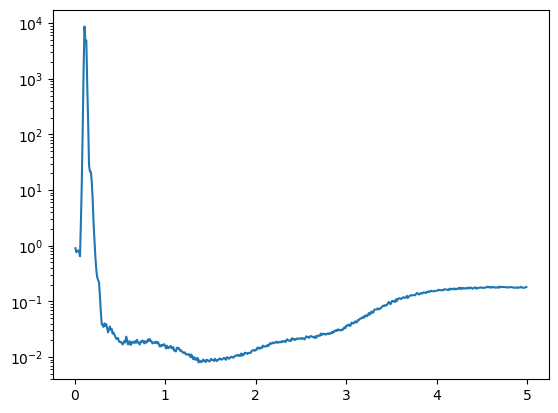

In [56]:

def relative_error(f,y):
    return ((f-y).T@(f-y))/(y.T@y)


errs = []
errs_t = []
cv = ShuffleSplit(n_splits=10, random_state=0)

l_range = np.arange(0.01,5, 0.01)
for l in l_range:
    err = 0
    err_t = 0
    eta = 5e-8
    T = t_sample.reshape(-1,1)
    for train, test in cv.split(T):
        scaler = StandardScaler()
        y_train = u_sample[train]
        x_train = T[train]
        x_train_scaled = scaler.fit_transform(x_train)
        y_test = u_t_sample[test]
        x_test = T[test]
        x_test_scaled = scaler.transform(x_test)
        u_t_star = smoothDif(x_train, x_test, y_train, 0, eta,l)
        err_t += relative_error(u_t_star, y_test)
        # err_t += mean_squared_error(u)
    # errs.append(err/10)
    errs_t.append(err_t/10)
    print(l, err_t/10)

lowest_index = errs_t.index(min(errs_t))
print('lowest l', l_range[lowest_index])
print(min(errs_t))

# plt.plot(g_range, errs)
plt.semilogy(l_range, errs_t)

0.01 0.00032193699496079316
0.015 0.00024834269600396353
0.019999999999999997 0.0001292426922167147
0.024999999999999998 5.485879302827753e-05
0.03 2.5129078737703277e-05
0.034999999999999996 1.8049743115017088e-05
0.039999999999999994 1.849029369548707e-05
0.045 2.139268130206914e-05
0.049999999999999996 2.5866917825164425e-05
0.05499999999999999 3.3342125087637426e-05
0.05999999999999999 4.966604374614901e-05
0.06499999999999999 9.152451317578862e-05
0.06999999999999999 0.00020909405161571252
0.07499999999999998 0.000567913261083222
0.07999999999999999 0.0017291785724551049
0.08499999999999998 0.0055266605900445055
0.08999999999999998 0.017517171709896896
0.09499999999999999 0.052813934647466296
0.09999999999999998 0.14245874580567436
0.10499999999999998 0.2581711346380658
0.10999999999999997 0.13924300577028706
0.11499999999999998 0.04004193415999173
0.11999999999999998 0.11490202166047252
0.12499999999999997 0.09617779230465202
0.12999999999999998 0.04558619683751966
0.134999999999

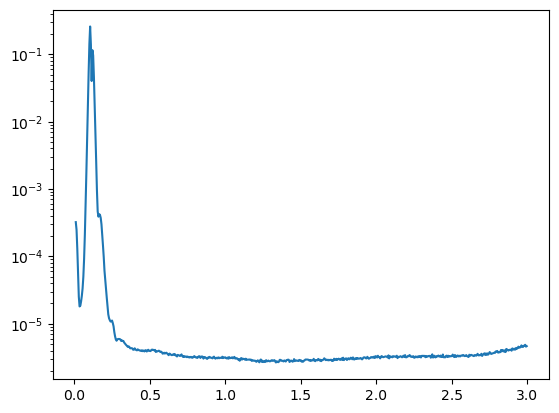

In [57]:
errs = []
cv = ShuffleSplit(n_splits=10, random_state=0)

l_range = np.arange(0.01, 3, 0.005)
for l in l_range:
    err = 0
    err_t = 0
    eta = 1e-7
    T = t_sample.reshape(-1,1)
    for train, test in cv.split(T):
        scaler = StandardScaler()
        y_train = u_sample[train]
        x_train = T[train]
        x_train_scaled = scaler.fit_transform(x_train)
        y_test = u_sample[test]
        x_test = T[test]
        x_test_scaled = scaler.transform(x_test)
        u_star = smooth(x_train, x_test, y_train, eta,l)
        err += mean_squared_error(u_star, y_test)
    errs.append(err/10)
    print(l, err/10)

lowest_index = errs.index(min(errs))
print('lowest l', l_range[lowest_index])
print(min(errs))

# plt.plot(g_range, errs)
plt.semilogy(l_range, errs)

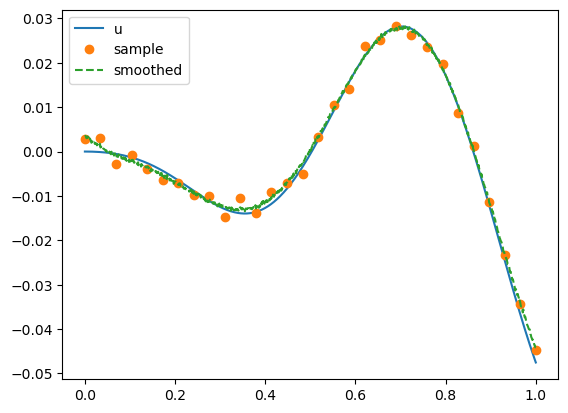

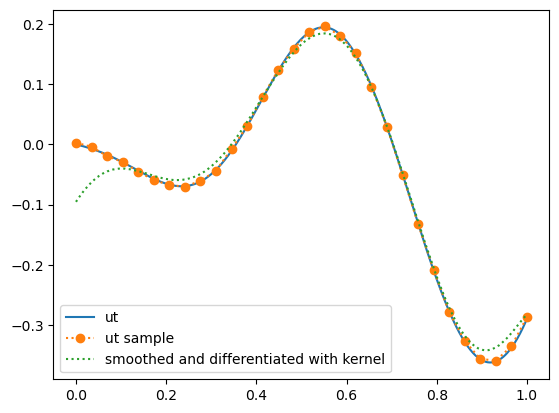

In [58]:
T_train = t_sample.reshape(-1,1)
T_train_scaled = scaler.fit_transform(T_train)

T_test = t.reshape(-1,1)
T_test_scaled = scaler.transform(T_test)

T = t.reshape(-1,1)

l = 1.335
lam = 5e-8
smoothed = smooth(T_train, T_test, u_sample, lam, l)
plt.plot(t,u, label='u')
plt.plot(t_sample, u_sample, 'o', label='sample')
plt.plot(t,smoothed, '--', label='smoothed')
plt.legend()

plt.figure()
smoothed_t = smoothDif(T_train, T_test, u_sample, 0, lam, l)
plt.plot(t,ut,label='ut')
plt.plot(t_sample,u_t_sample,'o:',label='ut sample')
plt.plot(t,smoothed_t,':',label='smoothed and differentiated with kernel')



plt.legend()

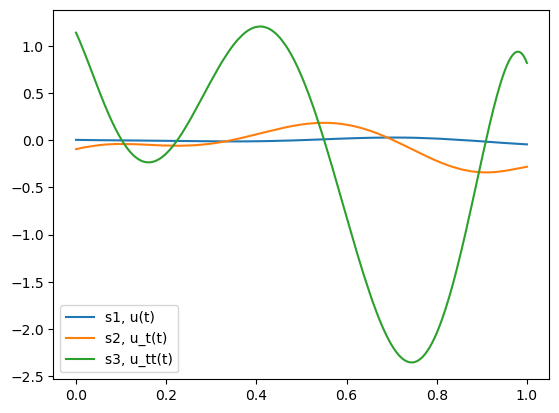

In [67]:
l = 1.335
lam = 5e-8

s1 = smooth(T_train, T_test, u_sample, lam, l)
s2 = smoothDif(T_train, T_test, u_sample, 0, lam, l)
s3 = smooth2ndDif(T_train, T_test, u_sample, 0, lam, l)

plt.plot(t, s1, label='s1, u(t)')
plt.plot(t, s2, label='s2, u_t(t)')
plt.plot(t, s3, label='s3, u_tt(t)')
plt.legend()